In [1]:
import pygmt 
import pandas as pd
import os,glob
import matplotlib.pyplot as plt
import pickle
from obspy.geodetics.base import gps2dist_azimuth

In [2]:
PATH = '/Volumes/home/Research/STEP/02_Station_result_csv/'
Lithnc = '/Volumes/home/Research/GMT/LithoThickness/LithThickness.nc'
Mohonc = '/Volumes/home/Research/DataBase/01_Armenia/04_Moho_fit_fromCM.nc'
PKLpath = '/Volumes/home/Research/STEP/01_Split'
Resultcsv='/Volumes/home/Research/STEP/05_Station_result_statistics/Station_SK(K)S_2010-2020average_v4.csv'
Volcanocsv='/Volumes/home/Research/DataBase/01_Armenia/02_Volcano_list.csv'
dr = pd.read_csv(Resultcsv)
dv = pd.read_csv(Volcanocsv)

In [3]:
regvals = [40, 47, 39.5, 44.5]
APM = 65

In [4]:
figmap = pygmt.Figure()
figmap.basemap(region=regvals, projection="M15c", frame = ['x1f0.5', 'y1f0.5', 'nSeW'])
figmap.grdimage('@earth_relief_30s',region =regvals, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)
figmap.coast(resolution = 'h', shorelines ='0.5/thinnest,black', water='white', borders = '1/0.3p')

figmap.plot(x=[41.3,45.7],y=[42,40],pen="1p,red")
figmap.text(x=[41.3,45.7],y=[42,40],text=['A','A"'],justify='TL')
for i in range(len(dv)):
    vlat= dv['lat'].values[i]
    vlon= dv['lon'].values[i]
    name= dv['VolcanoName'].values[i] 
    figmap.plot(x=vlon,y=vlat,style='t0.2c',color='red')
    figmap.text(x=vlon,y=vlat-0.15,text=name[0:4],font='7p')
    
for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    NET = values['network']; STA = values['station']
    st_lat = values['latitude']; st_lon = values['longitude']
    figmap.plot(x=st_lon,y=st_lat,style='c0.2c',color='black')


coast [WARNING]: Length <unit> t not supported - revert to default unit [point]
coast [WARNING]: 0.5/thinnes not a valid number and may not be decoded properly.


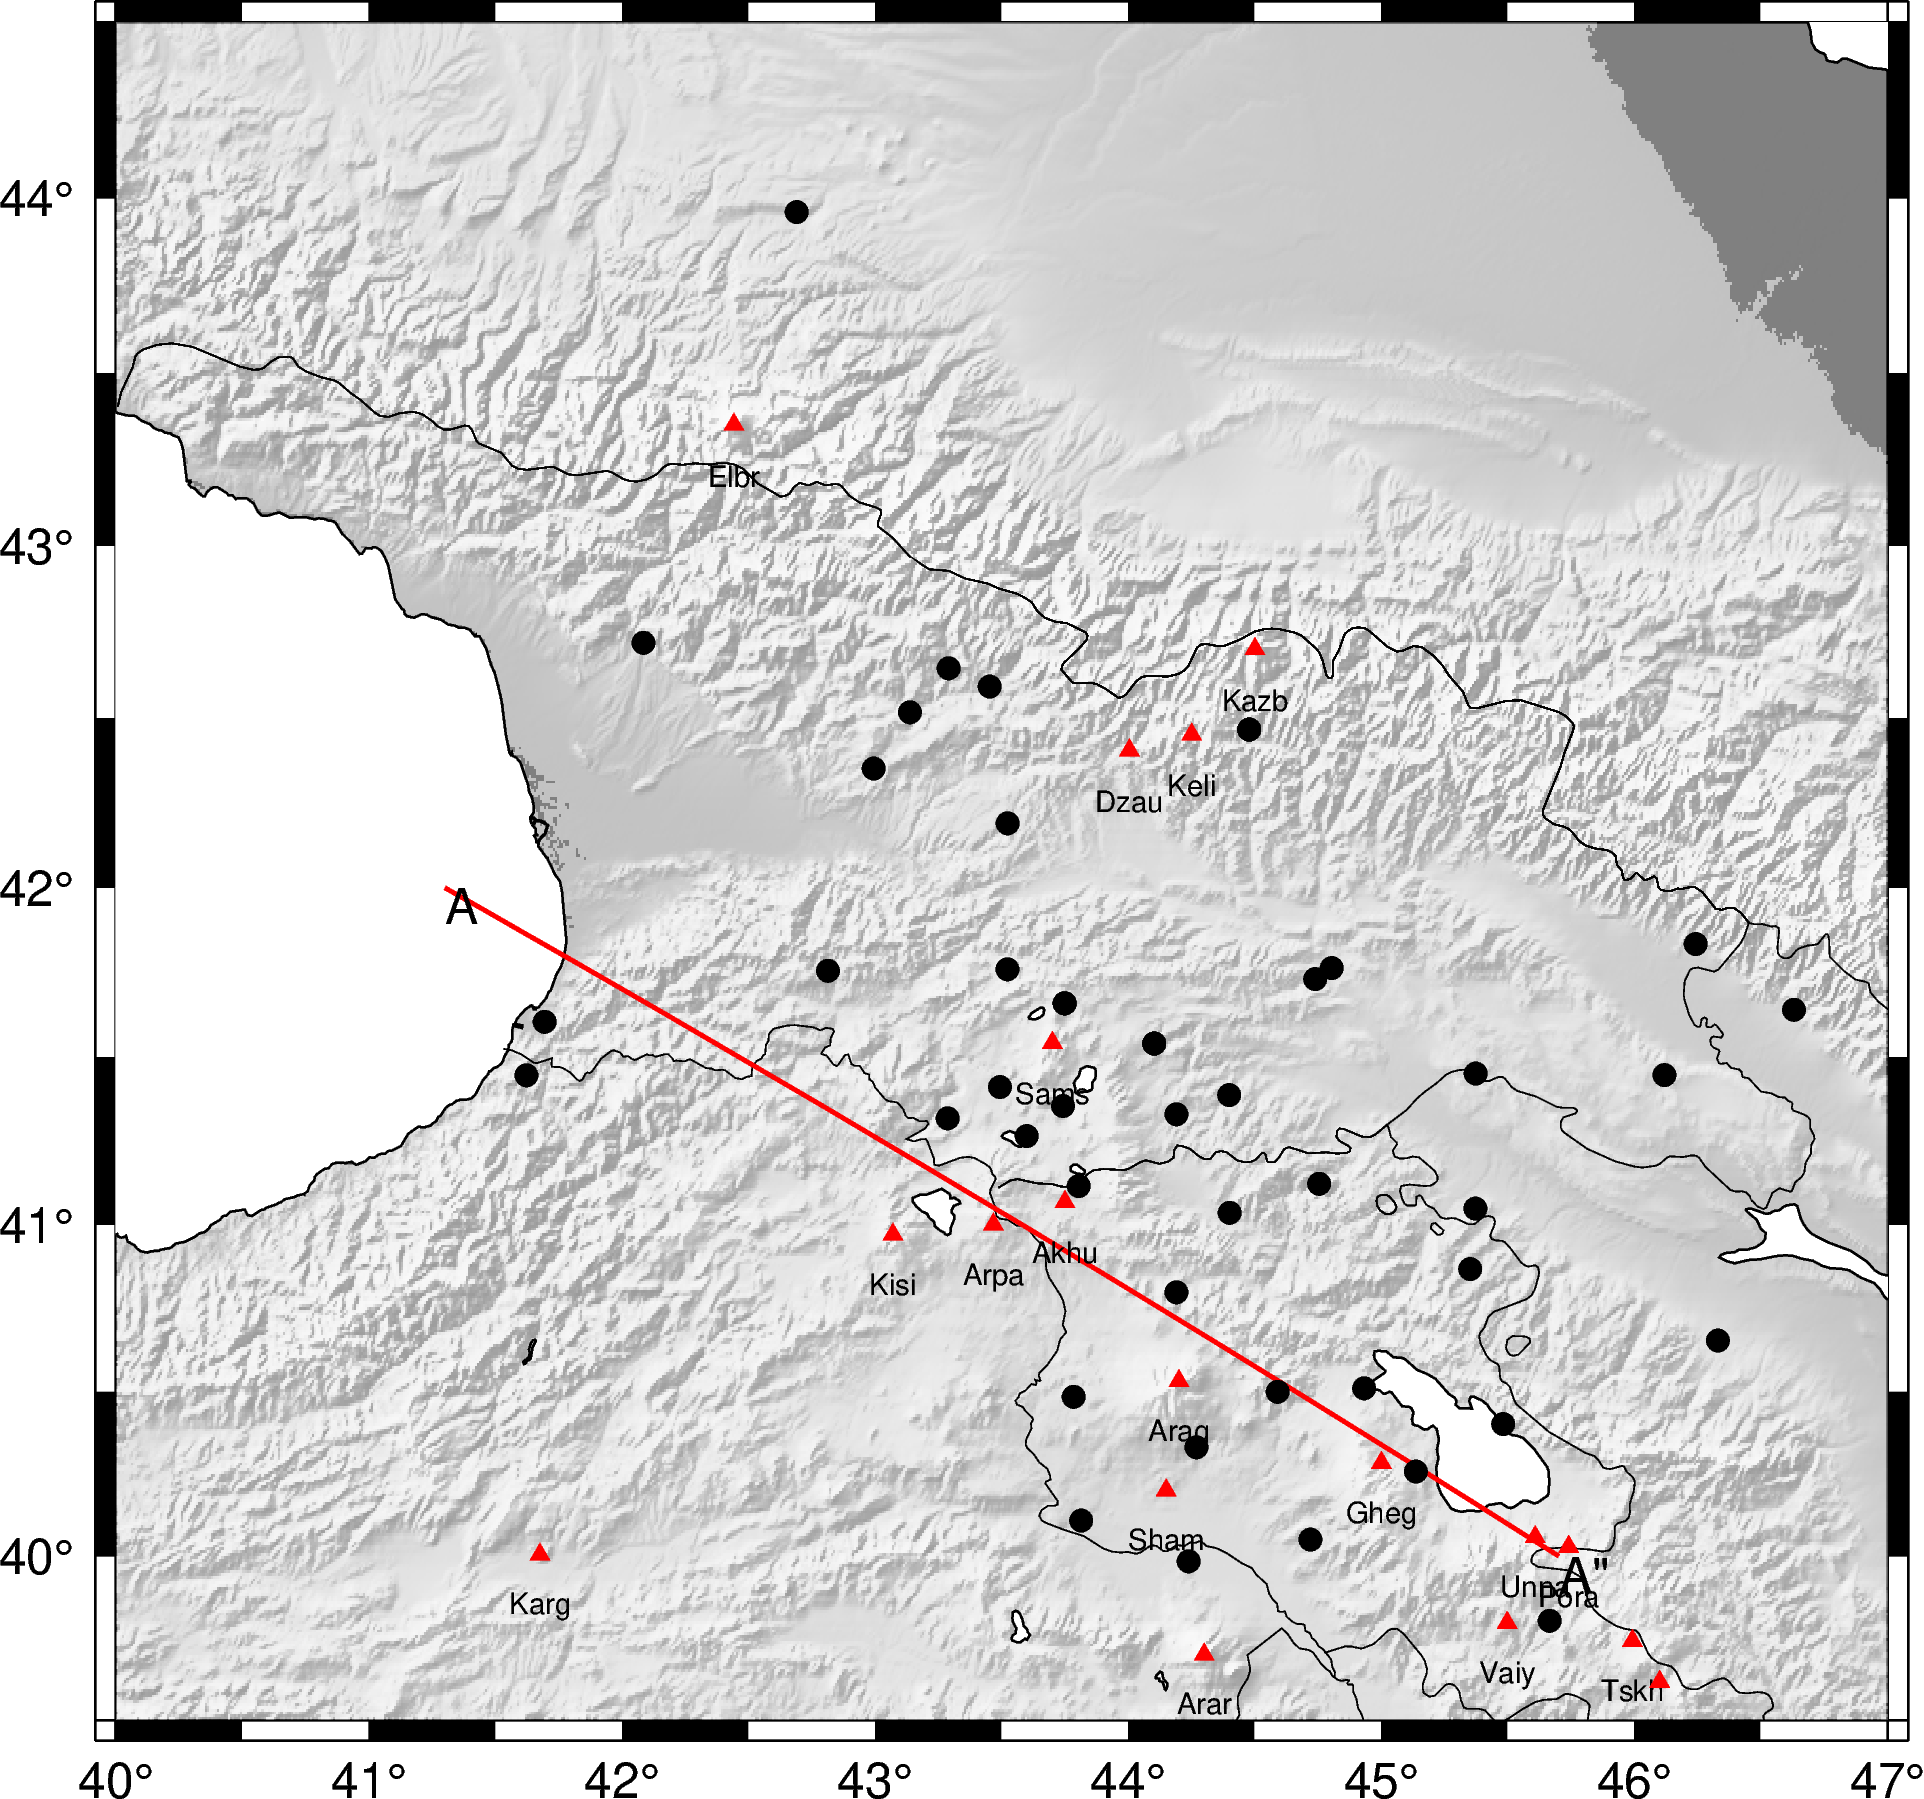

In [5]:
figmap.show()

In [6]:
volname=['Kisir Dagi','Arpacay','Akhuryan Valley','Samsari','Aragats','Shamiram Plateau','Ghegham','Vaiyots-Sar','Unnamed','Porak']

In [7]:
VOLDIST = []
PLOTtype= []
for name in volname:
    dv_lon = dv[dv['VolcanoName']==name]['lon'].values[0]
    dv_lat = dv[dv['VolcanoName']==name]['lat'].values[0]
    voltype= dv[dv['VolcanoName']==name]['Plottype'].values[0]
    cmd = '''
    echo %(dv_lon)f %(dv_lat)f | gmt project -C41.3/42 -E45.7/40 -Frs -Q
    ''' %locals()
    p = os.popen(cmd)
    text = str(p.read())
    p.close()
    p_lon=float(text.rsplit('\t')[0])
    p_lat=float(text.rsplit('\t')[-1].rsplit('\n')[0])
#     print(p_lon,p_lat)
    dist,az,baz = gps2dist_azimuth(p_lat,p_lon,42,41.3)
    VOLDIST.append(dist/1000)   
    PLOTtype.append(voltype)

In [8]:
points1 = pygmt.project(center=[41.3, 42], endpoint=[45.7, 40], generate=0.05,unit=True)
# figmap.plot(x=points1.r, y=points1.s, pen="2p,seagreen")

In [9]:
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=regvals)
trackfile = pygmt.grdtrack(points=points1,grid=grid,newcolname="bathymetry")

In [10]:
Lithfile = pygmt.grdtrack(points=points1,grid=Lithnc,newcolname="Thickness")
Mohofile = pygmt.grdtrack(points=points1,grid=Mohonc,newcolname="Thickness")

In [11]:
DIST = []
dtlist = []; ddtlist = []
philist = []; dphilist = []
notusedSTA = ['BATM','BGLV','CHVG','TKBL','AMBR','URAV','ONI','GUDG','GUDA','TBLG','SEAG','DGRG','DDFL','LGD','ZKT','GANJ','KIV']
for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    NET = values['network']; STA = values['station']
    if STA not in notusedSTA:
#         print(f'{NET}.{STA}')
        st_lat = values['latitude']; st_lon = values['longitude']
        cmd = '''
        echo %(st_lon)f %(st_lat)f | gmt project -C41.3/42 -E45.7/40 -Frs -Q
        ''' %locals()
        p = os.popen(cmd)
        text = str(p.read())
        p.close()
        p_lon=float(text.rsplit('\t')[0])
        p_lat=float(text.rsplit('\t')[-1].rsplit('\n')[0])
    #     print(p_lon,p_lat)
        dist,az,baz = gps2dist_azimuth(p_lat,p_lon,42,41.3)
        DIST.append(dist/1000)

        dt = dr[dr['Station']==f'{NET}.{STA}']['SCdt'].values[0]
        ddt = dr[dr['Station']==f'{NET}.{STA}']['SCddt'].values[0]
        phi = dr[dr['Station']==f'{NET}.{STA}']['SCphi'].values[0]
        dphi = dr[dr['Station']==f'{NET}.{STA}']['SCdphi'].values[0]
        dtlist.append(dt)
        ddtlist.append(ddt)
        dphilist.append(dphi)
        philist.append(phi)

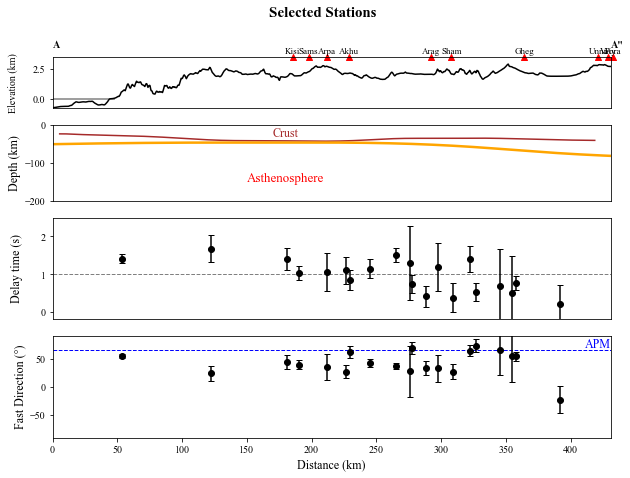

In [12]:
plt.rc('font',family='Times New Roman')
maxdist = max(Mohofile['p'])
fig, axs = plt.subplots(4,1,figsize=(10,7),gridspec_kw={'height_ratios': [1, 1.5, 2, 2]})
plt.subplot(411)
plt.xticks([])
plt.hlines(y=0,xmin=0,xmax=48,color='gray',ls='-')
plt.plot(trackfile['p'],trackfile['bathymetry']/1000,'k')
plt.xlim(0,maxdist)
plt.ylim(-0.8,3.5)
plt.ylabel('Elevation (km)\n', fontsize=10)
plt.scatter(VOLDIST,[3.5]*len(VOLDIST),color='r',marker='^',clip_on=False)
plt.text(x=0,y=4.3,s='A',fontsize=10,fontweight='bold')
plt.text(x=maxdist,y=4.3,s='A"',fontsize=10,fontweight='bold')
for i, vv in enumerate(volname):
    plt.text(x=VOLDIST[i],y=3.8,s=vv[0:4],clip_on=False,color='k',fontsize=9,ha='center')

plt.subplot(412)
plt.plot(Mohofile['p'],-1*Mohofile['Thickness'],c='brown')
plt.plot(Lithfile['p'],-1*Lithfile['Thickness'],c='orange',lw=2.5)
plt.xlim(0,maxdist)
plt.ylim(-200,0)
plt.xticks([])
plt.ylabel('Depth (km)', fontsize=12)
plt.text(x=180,y=-150,s='Asthenosphere',color='r',fontsize=13,ha='center')
plt.text(x=180,y=-30,s='Crust',color='brown',fontsize=12,ha='center')

plt.subplot(413)
plt.hlines(y=1,xmin=0,xmax=maxdist,ls='--',color='grey',lw=1)
plt.errorbar(DIST, dtlist, yerr = ddtlist, fmt='o',markeredgecolor='k',color ='k',ecolor='k',capsize=3) 
plt.ylim(-0.2,2.5)
plt.xlim(0,maxdist)
plt.xticks([])
plt.ylabel('Delay time (s)\n', fontsize=12)

plt.subplot(414)
plt.hlines(y=APM,xmin=0,xmax=maxdist,ls='--',color='b',lw=1)
plt.text(x=maxdist,y=APM-20,s='APM\n',c='blue',ha='right',fontsize=12)
plt.errorbar(DIST, philist, yerr = dphilist, fmt='o',markeredgecolor='k',color ='k',ecolor='k',capsize=3) 
plt.ylim(-90,90)
plt.xlim(0,maxdist)
plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Fast Direction (°)', fontsize=12)
plt.suptitle('Selected Stations',fontsize=15, fontweight='bold')
savedir = '/Volumes/home/Research/STEP/11_profile_variations'
# plt.savefig(f'{savedir}/ProfileA_v1.png',dpi=150)
# plt.savefig(f'{savedir}/ProfileA_v1.pdf')

## ProfileB

In [85]:
KOresult='/Volumes/home/Research/DataBase/02_SKS_splitting/Lemnifi_etal_Turkey_stations_averaged_DB.txt'
dK = pd.read_csv(KOresult,sep='\s+',names=['Station','lat','lon','phi','phi_std','dt','dt_std','Num'])

newdK = dK[dK['lat']>=39.5][dK['lon']>=40][dK['Station']!='GNIxxx_IU']

/var/folders/sp/pnngww1n0q31w2plgbk53rc00000gn/T/ipykernel_73885/727470975.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdK = dK[dK['lat']>=39.5][dK['lon']>=40][dK['Station']!='GNIxxx_IU']


coast [WARNING]: Length <unit> t not supported - revert to default unit [point]
coast [WARNING]: 0.5/thinnes not a valid number and may not be decoded properly.


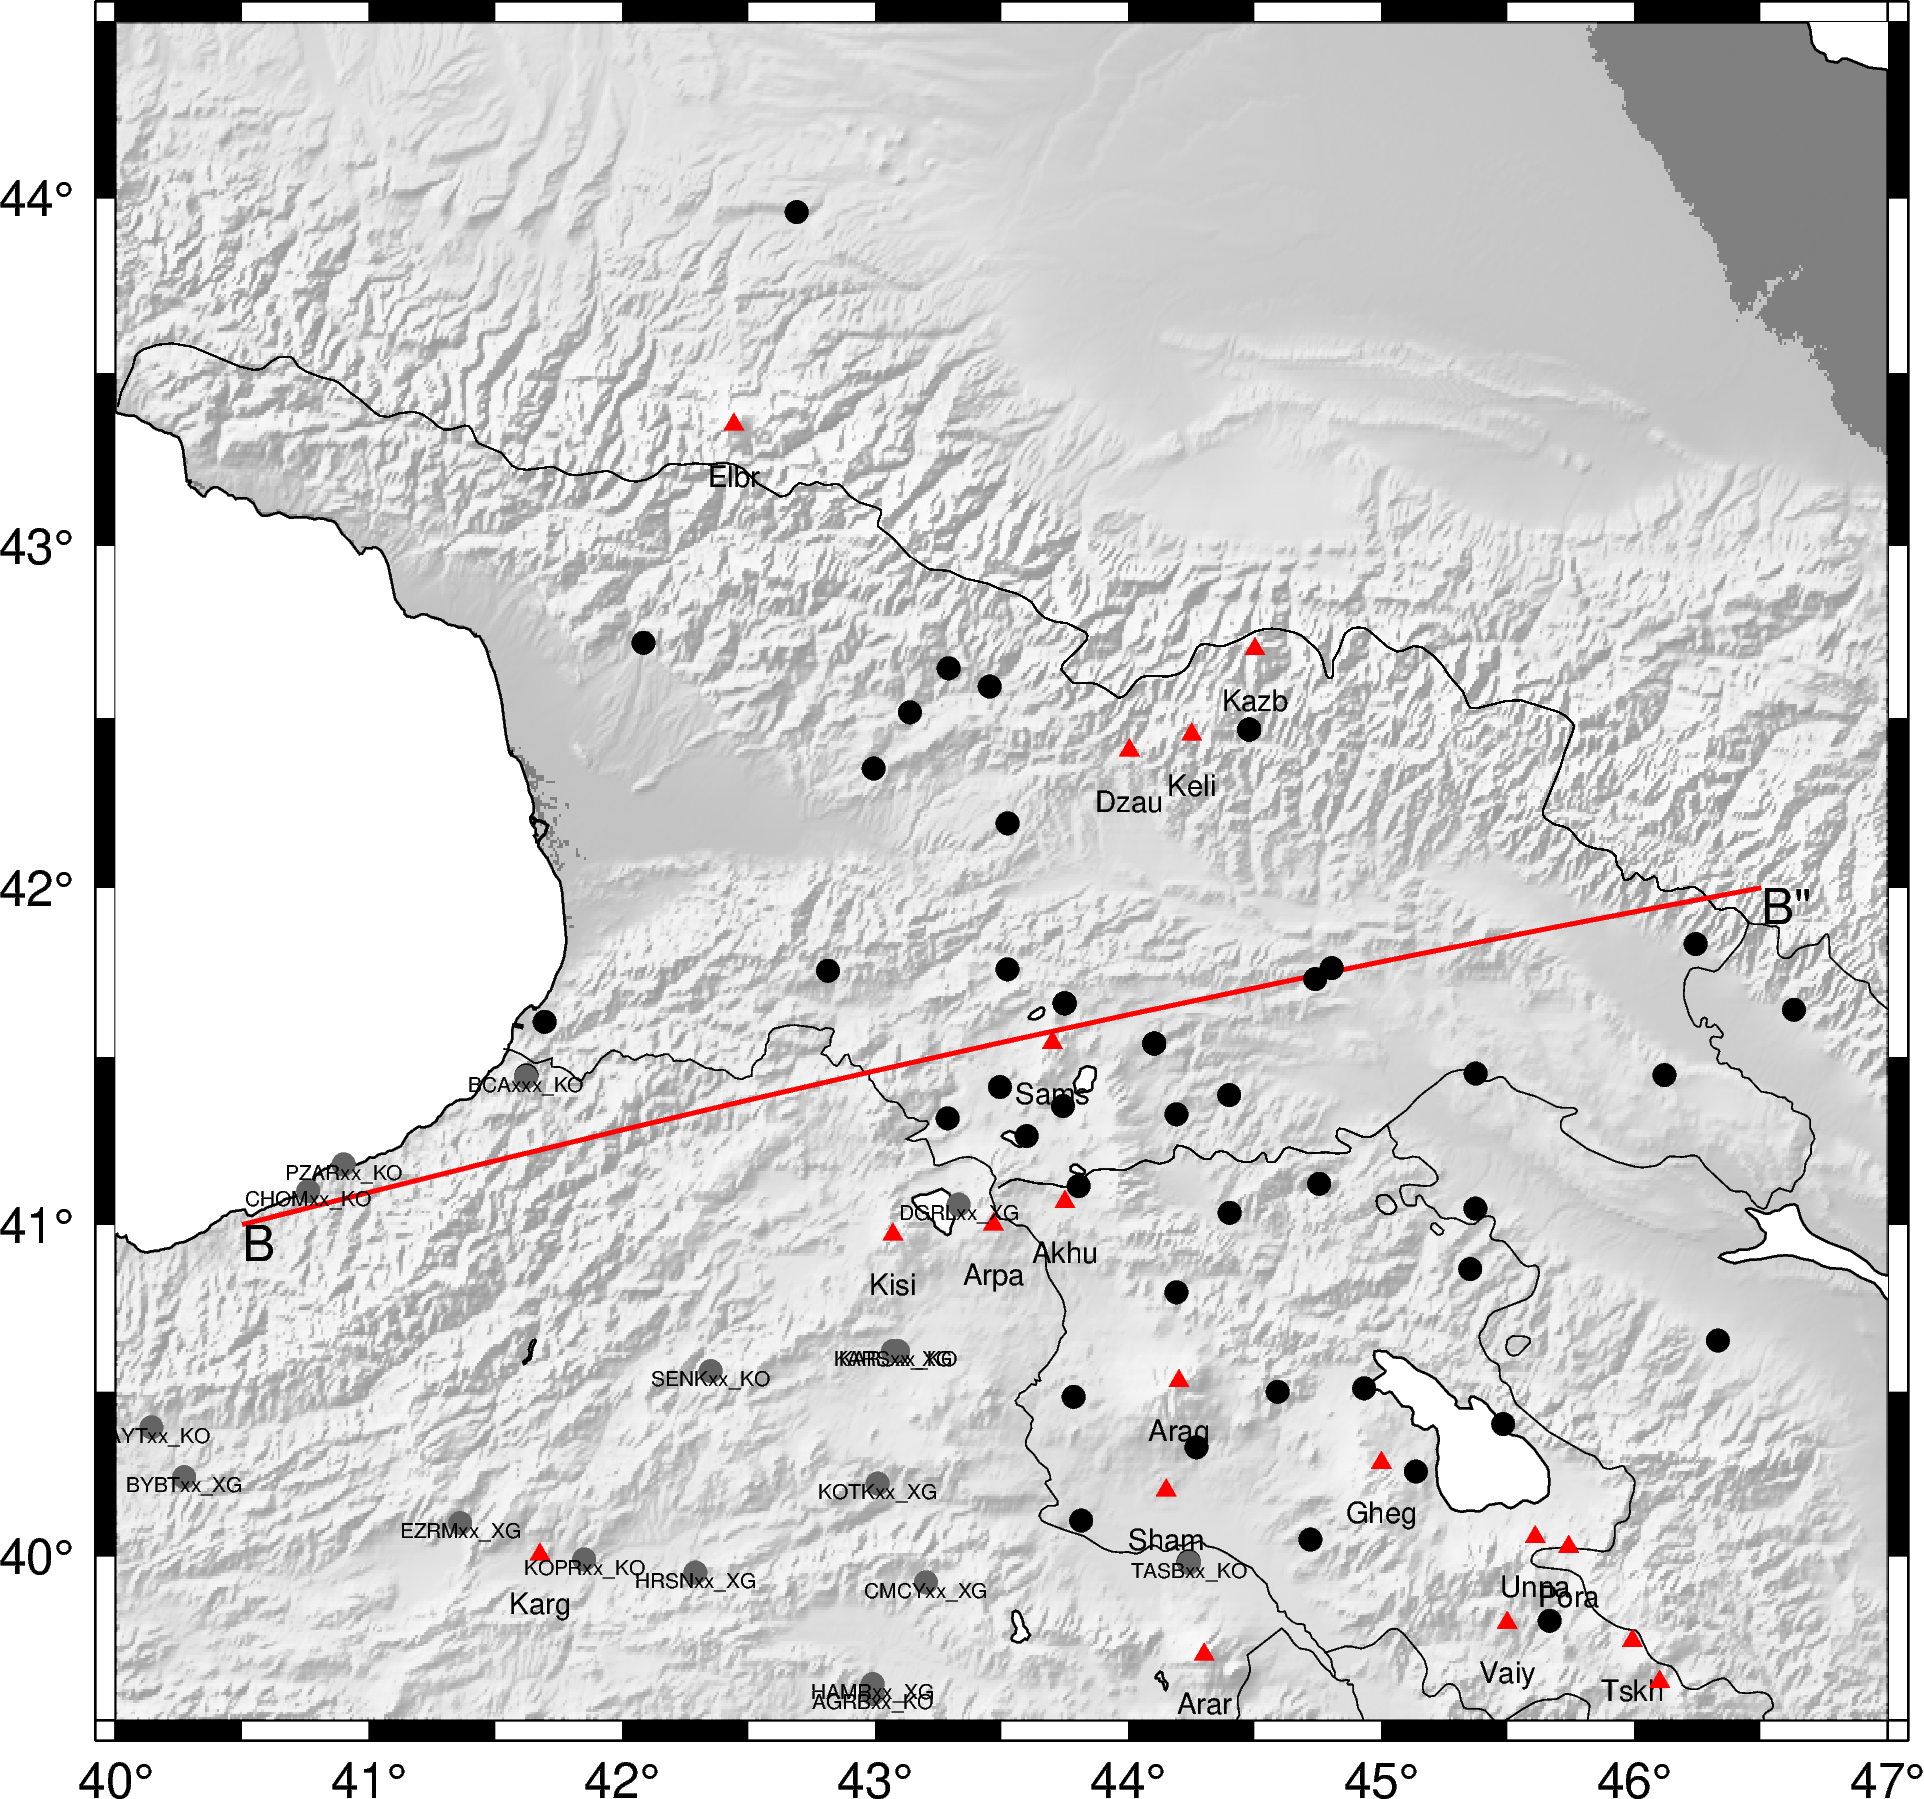

In [92]:
figmap = pygmt.Figure()
figmap.basemap(region=regvals, projection="M15c", frame = ['x1f0.5', 'y1f0.5', 'nSeW'])
figmap.grdimage('@earth_relief_30s',region =regvals, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)
figmap.coast(resolution = 'h', shorelines ='0.5/thinnest,black', water='white', borders = '1/0.3p')

figmap.plot(x=[40.5,46.5],y=[41,42],pen="1p,red")
figmap.text(x=[40.5,46.5],y=[41,42],text=['B','B"'],justify='TL')
for i in range(len(dv)):
    vlat= dv['lat'].values[i]
    vlon= dv['lon'].values[i]
    name= dv['VolcanoName'].values[i] 
    figmap.plot(x=vlon,y=vlat,style='t0.2c',color='red')
    figmap.text(x=vlon,y=vlat-0.15,text=name[0:4],font='7p')
    
for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    NET = values['network']; STA = values['station']
    st_lat = values['latitude']; st_lon = values['longitude']
    figmap.plot(x=st_lon,y=st_lat,style='c0.2c',color='black')
for i in range(len(newdK)):
    st_lat = newdK['lat'].values[i]; st_lon = newdK['lon'].values[i]
    sta = newdK['Station'].values[i]
    figmap.plot(x=st_lon,y=st_lat,style='c0.2c',color='100')
    figmap.text(x=st_lon,y=st_lat,text=sta,justify='TC',font='5p')
figmap.show()


In [93]:
volname=['Kisir Dagi','Arpacay','Akhuryan Valley','Samsari']

In [94]:
VOLDIST = []
PLOTtype= []
for name in volname:
    dv_lon = dv[dv['VolcanoName']==name]['lon'].values[0]
    dv_lat = dv[dv['VolcanoName']==name]['lat'].values[0]
    voltype= dv[dv['VolcanoName']==name]['Plottype'].values[0]
    cmd = '''
    echo %(dv_lon)f %(dv_lat)f | gmt project -C40.5/41 -E46.5/42 -Frs -Q
    ''' %locals()
    p = os.popen(cmd)
    text = str(p.read())
    p.close()
    p_lon=float(text.rsplit('\t')[0])
    p_lat=float(text.rsplit('\t')[-1].rsplit('\n')[0])
#     print(p_lon,p_lat)
    dist,az,baz = gps2dist_azimuth(p_lat,p_lon,41,40.5)
    VOLDIST.append(dist/1000)   
    PLOTtype.append(voltype)

In [34]:
points2 = pygmt.project(center=[40.5, 41], endpoint=[46.5, 42], generate=0.05,unit=True)

In [96]:
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=regvals)
trackfile = pygmt.grdtrack(points=points2,grid=grid,newcolname="bathymetry")

In [97]:
Lithfile = pygmt.grdtrack(points=points2,grid=Lithnc,newcolname="Thickness")
Mohofile = pygmt.grdtrack(points=points2,grid=Mohonc,newcolname="Thickness")

In [100]:
DIST = []
dtlist = []; ddtlist = []
philist = []; dphilist = []
usedSTA = ['BCA','ABST','AZMN','BAUR','BGD','GANZ','AKH','BURN','BUDG',\
           'BKRG','TRLT','TRLG','DMNI','KZRT','BAUR','TBLG','DDFL','LGD',\
          'CHOMxx_KO','PZARxx_KO','DGRLxx_XG']
for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    NET = values['network']; STA = values['station']
    if STA in usedSTA:
#         print(f'{NET}.{STA}')
        st_lat = values['latitude']; st_lon = values['longitude']
        cmd = '''
        echo %(st_lon)f %(st_lat)f | gmt project -C40.5/41 -E46.5/42 -Frs -Q
        ''' %locals()
        p = os.popen(cmd)
        text = str(p.read())
        p.close()
        p_lon=float(text.rsplit('\t')[0])
        p_lat=float(text.rsplit('\t')[-1].rsplit('\n')[0])
    #     print(p_lon,p_lat)
        dist,az,baz = gps2dist_azimuth(p_lat,p_lon,41,40.5)
        DIST.append(dist/1000)

        dt = dr[dr['Station']==f'{NET}.{STA}']['SCdt'].values[0]
        ddt = dr[dr['Station']==f'{NET}.{STA}']['SCddt'].values[0]
        phi = dr[dr['Station']==f'{NET}.{STA}']['SCphi'].values[0]
        dphi = dr[dr['Station']==f'{NET}.{STA}']['SCdphi'].values[0]
        dtlist.append(dt)
        ddtlist.append(ddt)
        dphilist.append(dphi)
        philist.append(phi)
for i in range(len(newdK)):
    
    st_lat = newdK['lat'].values[i]; st_lon = newdK['lon'].values[i]
    sta = newdK['Station'].values[i]
    if sta in usedSTA:
        cmd = '''
        echo %(st_lon)f %(st_lat)f | gmt project -C40.5/41 -E46.5/42 -Frs -Q
        ''' %locals()
        p = os.popen(cmd)
        text = str(p.read())
        p.close()
        p_lon=float(text.rsplit('\t')[0])
        p_lat=float(text.rsplit('\t')[-1].rsplit('\n')[0])
    #     print(p_lon,p_lat)
        dist,az,baz = gps2dist_azimuth(p_lat,p_lon,41,40.5)
        DIST.append(dist/1000)

        dt = newdK[newdK['Station']==sta]['dt'].values[0]
        ddt = newdK[newdK['Station']==sta]['dt_std'].values[0]
        phi = newdK[newdK['Station']==sta]['phi'].values[0]
        dphi = newdK[newdK['Station']==sta]['phi_std'].values[0]
        dtlist.append(dt)
        ddtlist.append(ddt)
        dphilist.append(dphi)
        philist.append(phi)

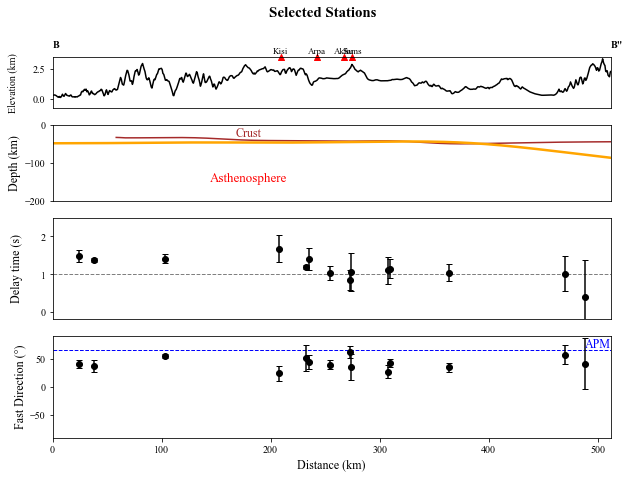

In [102]:
plt.rc('font',family='Times New Roman')
maxdist = max(Mohofile['p'])
fig, axs = plt.subplots(4,1,figsize=(10,7),gridspec_kw={'height_ratios': [1, 1.5, 2, 2]})
plt.subplot(411)
plt.xticks([])
plt.plot(trackfile['p'],trackfile['bathymetry']/1000,'k')
plt.xlim(0,maxdist)
plt.ylim(-0.8,3.5)
plt.ylabel('Elevation (km)\n', fontsize=10)
plt.scatter(VOLDIST,[3.5]*len(VOLDIST),color='r',marker='^',clip_on=False)
plt.text(x=0,y=4.3,s='B',fontsize=10,fontweight='bold')
plt.text(x=maxdist,y=4.3,s='B"',fontsize=10,fontweight='bold')
for i, vv in enumerate(volname):
    plt.text(x=VOLDIST[i],y=3.8,s=vv[0:4],clip_on=False,color='k',fontsize=9,ha='center')

plt.subplot(412)
plt.plot(Mohofile['p'],-1*Mohofile['Thickness'],c='brown')
plt.plot(Lithfile['p'],-1*Lithfile['Thickness'],c='orange',lw=2.5)
plt.xlim(0,maxdist)
plt.ylim(-200,0)
plt.xticks([])
plt.ylabel('Depth (km)', fontsize=12)
plt.text(x=180,y=-150,s='Asthenosphere',color='r',fontsize=13,ha='center')
plt.text(x=180,y=-30,s='Crust',color='brown',fontsize=12,ha='center')

plt.subplot(413)
plt.hlines(y=1,xmin=0,xmax=maxdist,ls='--',color='grey',lw=1)
plt.errorbar(DIST, dtlist, yerr = ddtlist, fmt='o',markeredgecolor='k',color ='k',ecolor='k',capsize=3) 
plt.ylim(-0.2,2.5)
plt.xlim(0,maxdist)
plt.xticks([])
plt.ylabel('Delay time (s)\n', fontsize=12)

plt.subplot(414)
plt.hlines(y=APM,xmin=0,xmax=maxdist,ls='--',color='b',lw=1)
plt.text(x=maxdist,y=APM-20,s='APM\n',c='blue',ha='right',fontsize=12)
plt.errorbar(DIST, philist, yerr = dphilist, fmt='o',markeredgecolor='k',color ='k',ecolor='k',capsize=3) 
plt.ylim(-90,90)
plt.xlim(0,maxdist)
plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Fast Direction (°)', fontsize=12)
plt.suptitle('Selected Stations',fontsize=15, fontweight='bold')
savedir = '/Volumes/home/Research/STEP/11_profile_variations'
plt.savefig(f'{savedir}/ProfileB_v1.png',dpi=150)
plt.savefig(f'{savedir}/ProfileB_v1.pdf')

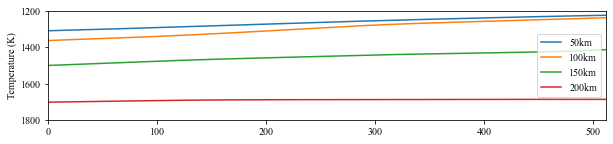

In [50]:
plt.subplots(figsize=(10,2))
ThermalDIR = '/Volumes/home/Research/GMT/ThermalModel'
for ThermalPath in glob.glob(f'{ThermalDIR}/*txt'):
    depth = ThermalPath.rsplit('_')[-1].rsplit('km')[0]
    thermal_mean = pygmt.blockmean(data=ThermalPath,region=[30, 50, 35, 50], spacing="0.1c/0.1c")
    pygmt.surface(data=thermal_mean,spacing="0.1c/0.1c",outgrid=f'{ThermalDIR}/thermal_{depth}km.grd')
    Thermalfile = pygmt.grdtrack(points=points2,grid=f'{ThermalDIR}/thermal_{depth}km.grd',newcolname="Temp")
    plt.plot(Thermalfile['p'],Thermalfile['Temp'],label=f'{depth}km')
plt.ylim(1800,1200)
plt.ylabel('Temperature (K)')
plt.xlim(0,max(Thermalfile['p']))
plt.legend()